In [8]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import uproot_methods
import networkx as nx
import glob
from matplotlib.colors import LogNorm

In [32]:
fi = np.load("experiments/delphes-gnn-04ab9bda/pred.npz")
ygen = fi["ygen"]
ycand = fi["ycand"]
ypred = fi["ypred"]

ygen = ygen.reshape((ygen.shape[0]*ygen.shape[1], ygen.shape[2]))
ycand = ycand.reshape((ycand.shape[0]*ycand.shape[1], ycand.shape[2]))
ypred = ypred.reshape((ypred.shape[0]*ypred.shape[1], ypred.shape[2]))

In [33]:
print(ygen.shape)
print(ycand.shape)
print(ypred.shape)

(512000, 7)
(512000, 7)
(512000, 7)


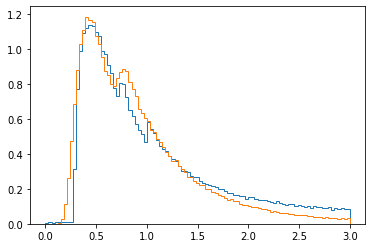

In [85]:
pid = 1
var = 2
bins = np.linspace(0, 3, 100)
msk = (ygen[:, 0] == pid)
plt.hist(ygen[msk, var], bins=bins, histtype="step", density=True);

msk = ycand[:, 0] == pid
plt.hist(ycand[msk, var], bins=bins, histtype="step", density=True);

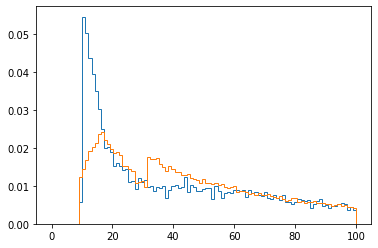

In [35]:
msk = (ygen[:, 0] == 2) & (ygen[:, 6] > 10)
plt.hist(ygen[msk, 6], bins=np.linspace(0, 100, 100), histtype="step", density=True);

msk = ycand[:, 0] == 2
plt.hist(ycand[msk, 6], bins=np.linspace(0, 100, 100), histtype="step", density=True);

In [36]:
ranges = {
    2: np.linspace(0, 10, 100),
    3: np.linspace(-5, 5, 100),
    4: np.linspace(-1, 1, 100),
    5: np.linspace(-1, 1, 100),
    6: np.linspace(0, 100, 100)
}

pid_names = {
    1: "charged hadrons",
    2: "neutral hadrons",
    3: "photons",
    4: "electrons",
    5: "muons",
}
var_names = {
    2: "pT",
    3: "eta",
    4: "sin phi",
    5: "cos phi",
    6: "E"
}

Text(0, 0.5, 'DelphesPF E')

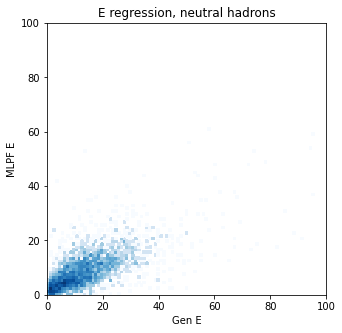

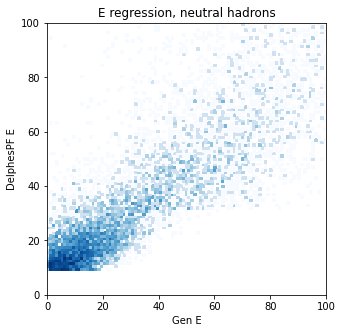

In [40]:
pid = 2
var_idx = 6
rng = ranges[var_idx]

msk = (ygen[:, 0]==pid) & (ypred[:, 0]==pid) & (ycand[:, 0]==pid)

plt.figure(figsize=(5,5))
plt.title("{} regression, {}".format(var_names[var_idx], pid_names[pid]))
plt.hist2d(
    ygen[msk, var_idx],
    ypred[msk, var_idx],
    bins=(rng, rng),
    cmap="Blues",
    norm=matplotlib.colors.LogNorm()
);
plt.xlabel("Gen {}".format(var_names[var_idx]))
plt.ylabel("MLPF {}".format(var_names[var_idx]))

msk = (ygen[:, 0]==pid) & (ycand[:, 0]==pid)
plt.figure(figsize=(5,5))
plt.title("{} regression, {}".format(var_names[var_idx], pid_names[pid]))
plt.hist2d(
    ygen[msk, var_idx],
    ycand[msk, var_idx],
    bins=(rng, rng),
    cmap="Blues",
    norm=matplotlib.colors.LogNorm()
);
plt.xlabel("Gen {}".format(var_names[var_idx]))
plt.ylabel("DelphesPF {}".format(var_names[var_idx]))

In [41]:
def plot_reso(pid, var_idx, rng):
    msk = (ygen[:, 0]==pid) & (ypred[:, 0]==pid) & (ycand[:, 0]==pid)
    bins = np.linspace(-rng, rng, 100)
    yg = ygen[msk, var_idx]
    yp = ypred[msk, var_idx]
    yc = ycand[msk, var_idx]
    ratio_mlpf = (yp - yg) / yg
    ratio_dpf = (yc - yg) / yg
    ratio_mlpf[yg==0] = -1
    ratio_dpf[yg==0] = -1

    plt.figure(figsize=(4,4))
    ax = plt.axes()
    plt.title("{} resolution for {}".format(var_names[var_idx], pid_names[pid]))
    plt.hist(ratio_mlpf, bins=bins, histtype="step", lw=1, density=1.0, label="MLPF\n$\mu={:.1f},\\ \sigma={:.1f}$".format(np.mean(ratio_mlpf), np.std(ratio_mlpf)));
    plt.hist(ratio_dpf, bins=bins, histtype="step", lw=1, density=1.0, label="DelphesPF\n$\mu={:.1f},\\ \sigma={:.1f}$".format(np.mean(ratio_dpf), np.std(ratio_dpf)));
    plt.legend(frameon=False)
    plt.ylim(0, ax.get_ylim()[1]*2)

In [42]:
def midpoints(x):
    return x[:-1] + np.diff(x)/2

Text(0, 0.5, 'fake rate')

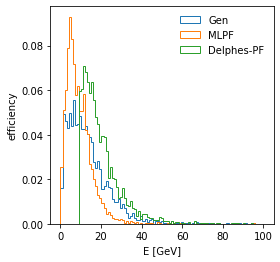

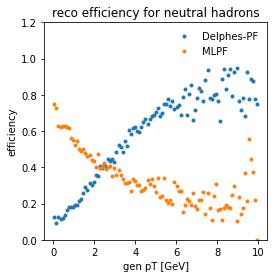

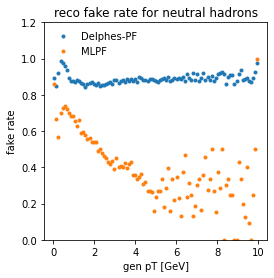

In [43]:
pid = 2

b = np.linspace(0, 10, 100)
msk_gen = ygen[:, 0]==pid
msk_pred = ypred[:, 0]==pid
msk_cand = ycand[:, 0]==pid
hist_gen = np.histogram(ygen[msk_gen, 2], bins=b);
hist_cand = np.histogram(ygen[msk_gen & msk_cand, 2], bins=b);
hist_pred = np.histogram(ygen[msk_gen & msk_pred, 2], bins=b);

plt.figure(figsize=(4,4))
plt.hist(ygen[msk_gen&msk_pred&msk_cand, 6], bins=np.linspace(0, 100, 100), label="Gen", histtype="step", density=True)
plt.hist(ypred[msk_gen&msk_pred&msk_cand, 6], bins=np.linspace(0, 100, 100), label="MLPF", histtype="step", density=True)
plt.hist(ycand[msk_gen&msk_pred&msk_cand, 6], bins=np.linspace(0, 100, 100), label="Delphes-PF", histtype="step", density=True)
plt.legend(frameon=False, loc="best")
#plt.ylim(0,1)
plt.xlabel("E [GeV]")
plt.ylabel("efficiency")

plt.figure(figsize=(4,4))
plt.title("reco efficiency for {}".format(pid_names[pid]))
plt.plot(midpoints(hist_gen[1]), hist_cand[0]/hist_gen[0], marker=".", lw=0, label="Delphes-PF")
plt.plot(midpoints(hist_gen[1]), hist_pred[0]/hist_gen[0], marker=".", lw=0, label="MLPF")
plt.legend(frameon=False, loc="best")
plt.ylim(0,1.2)
plt.xlabel("gen pT [GeV]")
plt.ylabel("efficiency")

hist_cand2 = np.histogram(ygen[msk_cand & (ygen[:, 0]!=0), 2], bins=b);
hist_pred2 = np.histogram(ygen[msk_pred & (ygen[:, 0]!=0), 2], bins=b);
hist_cand_gen2 = np.histogram(ygen[msk_cand & ~msk_gen & (ygen[:, 0]!=0), 2], bins=b);
hist_pred_gen2 = np.histogram(ygen[msk_pred & ~msk_gen & (ygen[:, 0]!=0), 2], bins=b);

plt.figure(figsize=(4,4))
plt.title("reco fake rate for {}".format(pid_names[pid]))
plt.plot(midpoints(hist_cand2[1]), hist_cand_gen2[0]/hist_cand2[0], marker=".", lw=0, label="Delphes-PF")
plt.plot(midpoints(hist_pred2[1]), hist_pred_gen2[0]/hist_pred2[0], marker=".", lw=0, label="MLPF")
plt.legend(frameon=False, loc="best")
plt.ylim(0,1.2)
plt.xlabel("gen pT [GeV]")
plt.ylabel("fake rate")

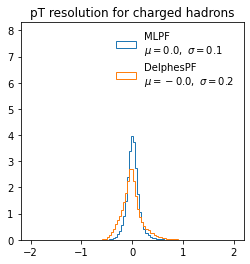

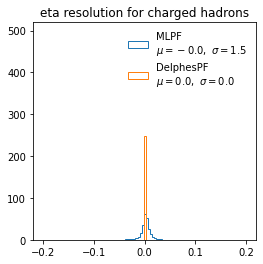

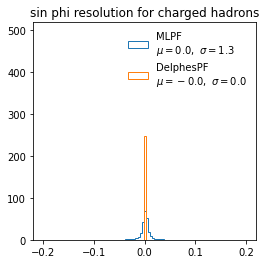

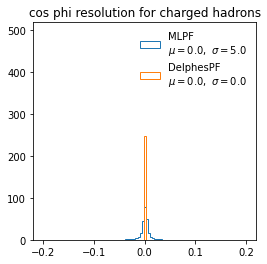

In [44]:
plot_reso(1, 2, 2)
plot_reso(1, 3, 0.2)
plot_reso(1, 4, 0.2)
plot_reso(1, 5, 0.2)

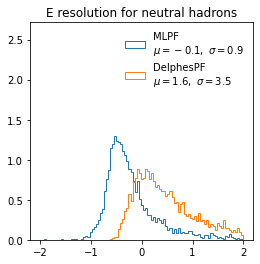

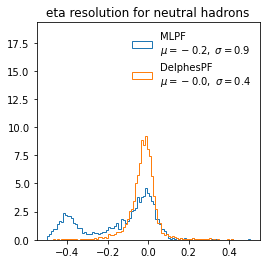

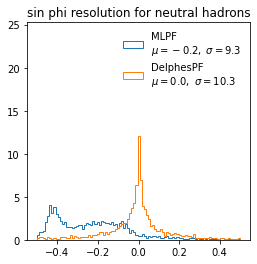

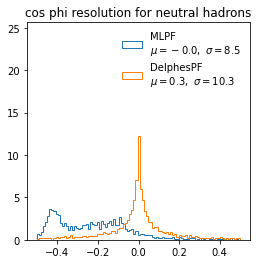

In [45]:
plot_reso(2, 6, 2)
plot_reso(2, 3, 0.5)
plot_reso(2, 4, 0.5)
plot_reso(2, 5, 0.5)

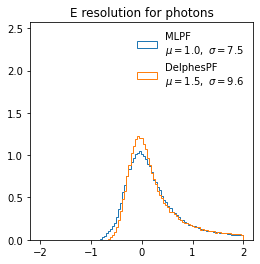

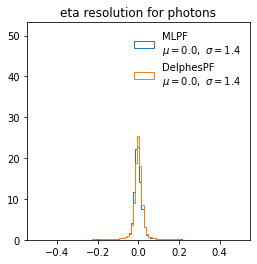

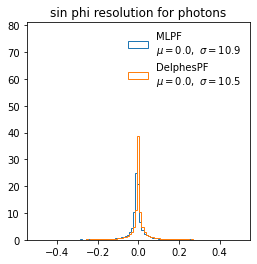

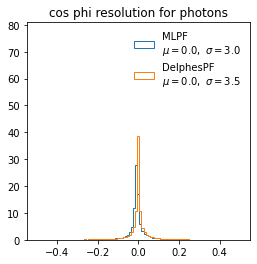

In [46]:
plot_reso(3, 6, 2)
plot_reso(3, 3, 0.5)
plot_reso(3, 4, 0.5)
plot_reso(3, 5, 0.5)

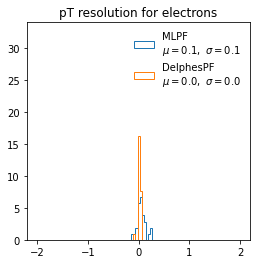

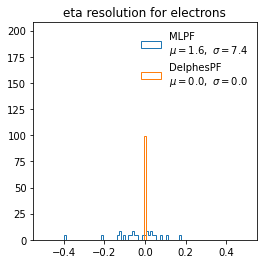

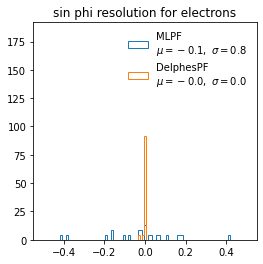

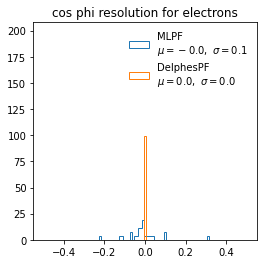

In [47]:
plot_reso(4, 2, 2)
plot_reso(4, 3, 0.5)
plot_reso(4, 4, 0.5)
plot_reso(4, 5, 0.5)

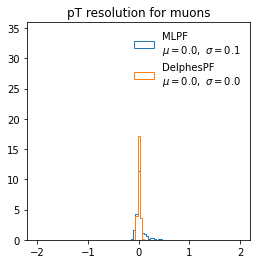

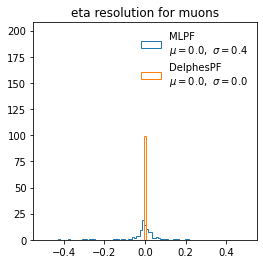

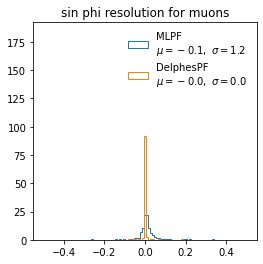

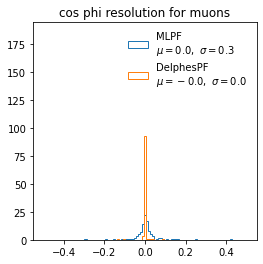

In [48]:
plot_reso(5, 2, 2)
plot_reso(5, 3, 0.5)
plot_reso(5, 4, 0.5)
plot_reso(5, 5, 0.5)

In [49]:
import sklearn
import sklearn.metrics

In [50]:
confusion = sklearn.metrics.confusion_matrix(
    ygen[:, 0], ycand[:, 0], normalize="true"
)

confusion2 = sklearn.metrics.confusion_matrix(
    ygen[:, 0], ypred[:, 0], normalize="true"
)

In [51]:
np.round(confusion, 2)

array([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.04, 0.7 , 0.26, 0.  , 0.  , 0.  ],
       [0.25, 0.  , 0.4 , 0.35, 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.99, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.26, 0.74, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]])

In [52]:
np.round(confusion2, 2)

array([[0.92, 0.  , 0.07, 0.01, 0.  , 0.  ],
       [0.  , 0.95, 0.05, 0.  , 0.  , 0.  ],
       [0.  , 0.24, 0.42, 0.34, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.72, 0.  , 0.24, 0.03, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]])

In [53]:
sklearn.metrics.accuracy_score(ygen[:, 0], ycand[:, 0])

0.780865234375

In [54]:
sklearn.metrics.accuracy_score(ygen[:, 0], ypred[:, 0])

0.930916015625

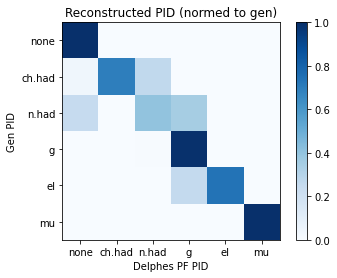

In [55]:
plt.imshow(confusion, cmap="Blues")
plt.title("Reconstructed PID (normed to gen)")
plt.xlabel("Delphes PF PID")
plt.ylabel("Gen PID")
plt.xticks(range(6), ["none", "ch.had", "n.had", "g", "el", "mu"]);
plt.yticks(range(6), ["none", "ch.had", "n.had", "g", "el", "mu"]);
plt.colorbar()

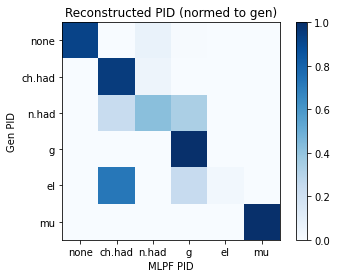

In [56]:
plt.imshow(confusion2, cmap="Blues")
plt.title("Reconstructed PID (normed to gen)")
plt.xlabel("MLPF PID")
plt.ylabel("Gen PID")
plt.xticks(range(6), ["none", "ch.had", "n.had", "g", "el", "mu"]);
plt.yticks(range(6), ["none", "ch.had", "n.had", "g", "el", "mu"]);
plt.colorbar()